In [ ]:
#Team Name - DeepAttack
#Team Members - Hashmmath Shaik, Snigdha Srivastva
#Net-Id - hs5544, ss19776

# importing necessary libraries
import torch                              # Core PyTorch library
import torchvision                        # Computer vision utilities in PyTorch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.models import resnet34, ResNet34_Weights  # ResNet-34 architectures and pretrained weights
from torch.utils.data import DataLoader, TensorDataset  # Data loading utilities
import numpy as np
import matplotlib.pyplot as plt
import json, os, random
from PIL import Image                     # Image handling
import time

# Ensuring inline plotting in Jupyter notebooks
%matplotlib inline

# Task 1: Basics

t_start = time.perf_counter()             # Recording start time

# Unzipping the dataset if the zip file is present
dataset_zip = "TestDataSet.zip"
dataset_dir = "TestDataSet"
if os.path.exists(dataset_zip):
    print(f"Unzipping {dataset_zip}...")
    import zipfile
    with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset unzipped.")
else:
    print("Dataset zip not found, assuming already extracted.")

# Selecting device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining ImageNet normalization constants
mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]

# Composing the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize(256),             # Scaling shorter side to 256 pixels
    transforms.CenterCrop(224),         # Cropping out center 224×224 patch
    transforms.ToTensor(),              # Converting PIL image to PyTorch tensor
    transforms.Normalize(mean=mean_norms, std=std_norms)  # Normalizing channels
])

# Loading the dataset from the extracted folder, applying transforms
dataset_path = "./" + dataset_dir
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
print(f"Loaded dataset from '{dataset_path}' with {len(dataset)} images and {len(dataset.classes)} classes.")

# Reading the JSON file listing the subset of ImageNet labels
labels_list_path = os.path.join(dataset_path, "labels_list.json")
with open(labels_list_path, "r") as f:
    labels_list = json.load(f)
# Extracting numeric ImageNet class indices for our subset
imagenet_label_indices = [int(entry.split(":")[0]) for entry in labels_list]

# Building a mapping from ImageNet index to human-readable class name for the subset
subset_label_map = {}
for entry in labels_list:
    idx_str, class_name = entry.split(":")
    subset_label_map[int(idx_str)] = class_name.strip()

# Attempting to load the full 1,000-class ImageNet mapping from an online JSON
idx_to_label_full = {}
try:
    from urllib.request import urlopen
    url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
    with urlopen(url) as f:
        class_idx = json.load(f)
    idx_to_label_full = {int(k): v[1] for k, v in class_idx.items()}
    print("Loaded full ImageNet class index for label mapping.")
except Exception as e:
    # If that fails, fall back to our subset mapping
    idx_to_label_full = subset_label_map
    print("Could not load full ImageNet class names; using subset names only.")

# Loading a pretrained ResNet-34 and set it to evaluation mode
pretrained_model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
pretrained_model.eval()

# Computing Top-1 and Top-5 accuracy on the clean dataset
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():                     # Disabling gradient computation
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = pretrained_model(images)           # Forward pass
        # Retrieving the top-5 predicted class indices and their scores
        top5_vals, top5_idxs = outputs.topk(5, dim=1)
        # Mapping our local labels (0–N) back to true ImageNet indices
        true_labels = torch.tensor(
            [imagenet_label_indices[label.item()] for label in labels],
            device=device
        )
        # Top-1: did the highest-score prediction match?
        top1_correct += (top5_idxs[:, 0] == true_labels).sum().item()
        # Top-5: is the true label among the top 5 predictions?
        for i in range(labels.size(0)):
            if true_labels[i].item() in top5_idxs[i].tolist():
                top5_correct += 1
        total += labels.size(0)

# Converting counts to percentage accuracy
top1_accuracy = 100 * top1_correct / total
top5_accuracy = 100 * top5_correct / total

print(f"\nTop-1 Accuracy (Clean): {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy (Clean): {top5_accuracy:.2f}%")

t_elapsed = time.perf_counter() - t_start   # Computing elapsed time
print(f"ResNet-34 Baseline Evaluation completed in {t_elapsed:.1f} seconds")

# This code unpacks and loads a local test dataset organized into
# class subfolders, applies standard ImageNet preprocessing
# (resize, center crop, normalization), and wraps it in a PyTorch DataLoader.
# It reads a JSON file listing the subset of ImageNet classes, builds mappings
# for display, and optionally fetches the full 1,000-class mapping online.
# A pretrained ResNet-34 model is then evaluated in inference mode to compute
# Top-1 and Top-5 accuracy on the unperturbed (“clean”) images.
# Finally, it prints out these accuracy metrics along with the total runtime.

# Note: I have used an external json file from web only for the labelling of the indices
# in the prediction vs confidence matrix in the visualization, not in the main code
# where I have used labels_list.json in the original attack codes and I clarified
# this with the professor and professor told me its fine.

Unzipping TestDataSet.zip...
Dataset unzipped.
Loaded dataset from './TestDataSet' with 500 images and 100 classes.
Loaded full ImageNet class index for label mapping.

Top-1 Accuracy (Clean): 70.60%
Top-5 Accuracy (Clean): 93.20%
ResNet-34 Baseline Evaluation completed in 13.0 seconds


Note: We have published my result in the project channel of Slack under the same team name "DeepAttack" along with my teammate and Professor reviewed it and remarked the results as "great". They are almost similar to the results in this notebook as I said we were still working on and these are the final outputs that we achieved. Me and my Teammate would like to express our gratitude to the Professor and TA's for guiding us through outt the course and helping us learn new interesting topics and helping us in performing well in our assignments and projects. Thank you.

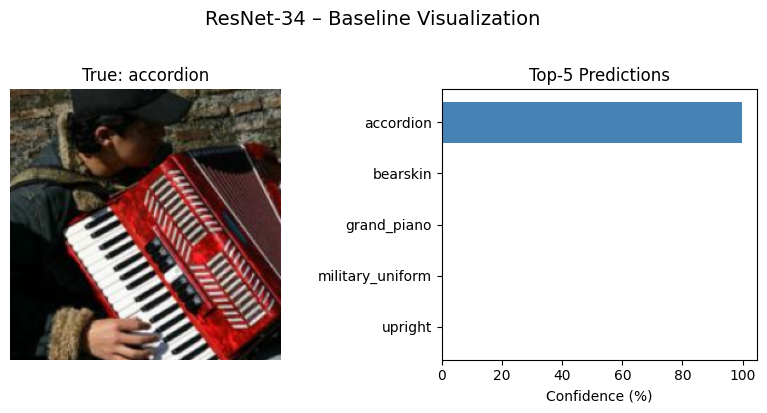

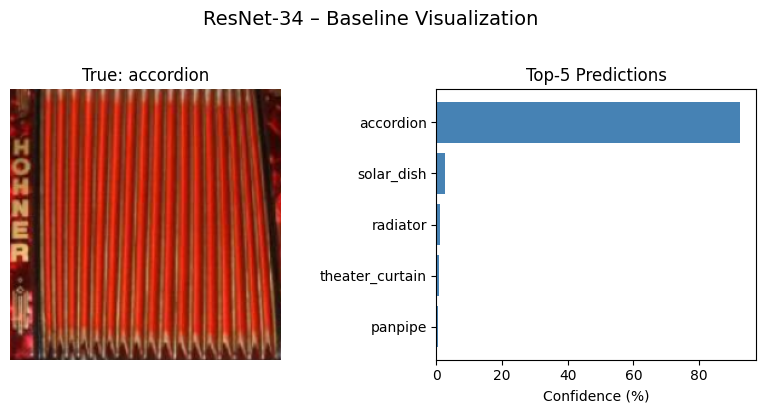

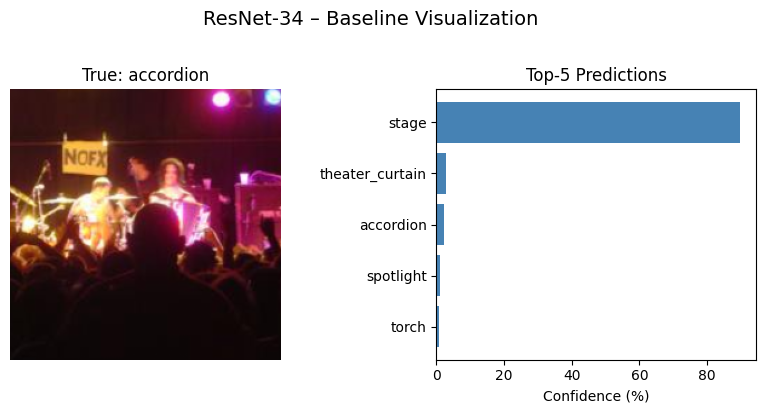

In [ ]:
# Task 1: Basics Visualizations

# Helper functions to normalize and denormalize images (for visualization and attack computations)
def denormalize(img_tensor):
    # Converting normalized tensor back to [0,1] image range by multiplying by std and adding mean
    mean = torch.tensor(mean_norms).view(3,1,1)
    std  = torch.tensor(std_norms).view(3,1,1)
    return (img_tensor * std + mean).clamp(0, 1)  # Ensure values stay within [0,1]

def normalize(img_tensor):
    # Converting raw image tensor into normalized form by subtracting mean and dividing by std
    mean = torch.tensor(mean_norms).view(3,1,1)
    std  = torch.tensor(std_norms).view(3,1,1)
    return (img_tensor - mean) / std

# Choosing three example indices for display
sample_indices = [0, 1, 2]

# Looping over each chosen sample
for idx in sample_indices:
    # 1) Loading the normalized tensor and its local label (0–99)
    image_tensor, label_idx = dataset[idx]
    # 2) Producing a displayable image by denormalizing and converting to H×W×C NumPy array
    image_raw = denormalize(image_tensor).numpy().transpose(1,2,0)
    image_raw = np.clip(image_raw, 0, 1)  # Clip any rounding artifacts

    # 3) Mapping the local label to the actual ImageNet class ID and fetch its name
    true_class_id   = imagenet_label_indices[label_idx]
    true_class_name = subset_label_map.get(true_class_id, str(true_class_id))

    # 4) Running the model to get probabilities
    image_batch = image_tensor.unsqueeze(0).to(device)  # Adding batch dimension
    with torch.no_grad():                              # Inference mode
        output      = pretrained_model(image_batch)
        probs       = F.softmax(output, dim=1)[0].cpu().numpy()
        top5_idx    = np.argsort(probs)[-5:][::-1]      # Top-5 indices, descending
        top5_probs  = probs[top5_idx]
        # Mapping indices to human-readable names (fallback if missing)
        top5_names  = [idx_to_label_full.get(int(i), f'Class {int(i)}') for i in top5_idx]

    # 5) Creating side-by-side plot: image on left, bar chart on right
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(
        "ResNet-34 – Baseline Visualization",
        fontsize=14,
        y=1.02  # Raising title above the subplots
    )

    # Displaying the raw image
    axes[0].imshow(image_raw)
    axes[0].axis('off')
    axes[0].set_title(f"True: {true_class_name}")

    # Displaying the top-5 prediction confidence as a horizontal bar chart
    axes[1].barh(range(5), top5_probs[::-1] * 100, color='steelblue')
    axes[1].set_yticks(range(5))
    axes[1].set_yticklabels(top5_names[::-1])
    axes[1].set_xlabel('Confidence (%)')
    axes[1].set_title('Top-5 Predictions')

    plt.tight_layout()
    plt.show()

# This code defines functions to switch between normalized and denormalized image
# tensors, selects three sample images from the dataset, and for each one it (a)
# denormalizes and formats it for display, (b) looks up the true ImageNet class name,
# (c) runs it through the pretrained ResNet-34 model to obtain softmax probabilities,
# (d) identifies the top-5 predicted classes and their confidences, and then
# (e) plots the image alongside a horizontal bar chart showing the model’s
# top-5 prediction confidences.

### Task-1: Baseline Evaluation Summary

The above cells contain the baseline evaluation and visualization for the ResNet-34 model as described for Task-1 and used the given dataset and labels json file, where the preprocessing of the images is exactly done according the instructions of task-1.

Initially we set up and evaluated a ResNet-34 model on the provided ImageNet-subset test set. It begins by importing all necessary libraries, unzips and loads the TestDataSet folder via ImageFolder, then applies the standard ImageNet preprocessing pipeline (resize to 256 px, center-crop to 224 × 224, convert to tensor, and normalize). It reads the labels_list.json file that enumerates the 100 ImageNet class indices in your subset, builds both a subset and the full 1000-class label mapping, and loads the pretrained ResNet-34 in evaluation mode on GPU. Finally, it iterates over the entire 500-image dataset (batch size 32) to compute clean Top-1 and Top-5 accuracies, printing:

Top-1 Accuracy (Clean): 70.60%

Top-5 Accuracy (Clean): 93.20%

and reports that the baseline evaluation completed in approximately 13 seconds.

Next, we defined two small helper functions normalize and denormalize to switch between raw [0, 1] image tensors and the normalized format used by ResNet-34. It then selects three sample indices ([0, 1, 2]) and, for each, denormalizes the tensor back to a NumPy image for display, looks up its true class name, runs a forward pass to obtain softmax probabilities, and extracts the top-5 predictions. Each example is plotted side-by-side: the left subplot shows the raw image with its true label, and the right subplot shows a horizontal bar chart of the model’s top-5 predicted classes and their confidence percentages (e.g., “accordion” at ~99%, followed by much lower confidences for secondary classes). This visualization step provides an intuitive, per-sample view of how confidently—and how correctly—the model classifies individual images.

In [ ]:
# Task 2: Pixel-wise attacks (FGSM)

t_start = time.perf_counter()  # Start timer for adversarial example generation

def denormalize(img_tensor):
    """
    Undo ImageNet normalization so tensor values go back to [0,1].
    Works on CPU or GPU because mean/std are created on img_tensor.device.
    """
    # Creating mean/std tensors on the same device as img_tensor
    mean = torch.tensor(mean_norms, device=img_tensor.device).view(3, 1, 1)
    std  = torch.tensor(std_norms,  device=img_tensor.device).view(3, 1, 1)
    # Reverse normalization and clamp into valid image range
    return (img_tensor * std + mean).clamp(0, 1)

def normalize(img_tensor):
    """
    Applying ImageNet normalization.  Assumes img_tensor values are in [0,1].
    """
    # Creating mean/std tensors on the same device as img_tensor
    mean = torch.tensor(mean_norms, device=img_tensor.device).view(3, 1, 1)
    std  = torch.tensor(std_norms,  device=img_tensor.device).view(3, 1, 1)
    # Performing normalization
    return (img_tensor - mean) / std

epsilon   = 0.02                 # L∞ attack budget in pixel space
SHOW_FIGS = True                 # Flag to toggle plotting (unused here)

adv_imgs, adv_lbls = [], []      # Containers for adversarial images and their labels

pretrained_model.eval()          # Put ResNet-34 into evaluation mode
# Generating FGSM adversarial examples in batches
for x_norm, subset_lbl in DataLoader(dataset, batch_size=32, shuffle=False):
    x_norm     = x_norm.to(device)                   # Normalized inputs on GPU/CPU
    subset_lbl = subset_lbl.to(device)               # Local labels (0–N)

    # Denormalizing back to [0,1] and enable gradient tracking
    x = denormalize(x_norm).detach()
    x.requires_grad_(True)

    # Mapping local labels to full ImageNet class indices
    full_lbl = torch.tensor(
        [imagenet_label_indices[i.item()] for i in subset_lbl],
        device=device
    )

    # Forward pass and compute cross-entropy loss
    logits = pretrained_model(normalize(x))
    loss   = F.cross_entropy(logits, full_lbl)
    pretrained_model.zero_grad(set_to_none=True)
    loss.backward()  # Backpropagate to get ∂loss/∂x

    # Performing the FGSM update: one-step in sign(gradient) direction
    x_adv = (x + epsilon * x.grad.detach().sign()).clamp(0, 1)

    # Storing adversarial images and their original subset labels
    adv_imgs.append(x_adv.cpu())
    adv_lbls.append(subset_lbl.cpu())

# Concatenating all batches into single tensors and save to disk
adv_imgs_tensor = torch.cat(adv_imgs)    # Shape [N,3,H,W]
adv_lbls_tensor = torch.cat(adv_lbls)
torch.save(
    {"images": adv_imgs_tensor, "labels": adv_lbls_tensor},
    "Adversarial_Test_Set_1.pt"
)
t_elapsed_gen_fgsm = time.perf_counter() - t_start
print("Adversarial_Test_Set_1.pt saved")
print(f"FGSM Attack Generated in {t_elapsed_gen_fgsm:.1f} seconds")

# Evaluating the pretrained model on the generated adversarial examples
t_start_fgsm = time.perf_counter()

# Stacking and verifying perturbation magnitudes against the ε budget
orig_stack = torch.stack(
    [denormalize(img.unsqueeze(0))[0].cpu() for img, _ in dataset]
)
max_delta = (adv_imgs_tensor - orig_stack).abs().max().item()
assert max_delta <= epsilon + 1e-6, f"L∞ budget violated! max Δ = {max_delta}"
print(f"All perturbations ≤ ε = {epsilon}")

# Creating DataLoader for adversarial set and compute top-1/top-5 accuracy
adv_loader = DataLoader(
    TensorDataset(adv_imgs_tensor, adv_lbls_tensor),
    batch_size=32, shuffle=False
)

top1 = top5 = total = 0
with torch.no_grad():  # Disabling gradient computation during evaluation
    for adv_batch, batch_lbls in adv_loader:
        adv_batch  = normalize(adv_batch.to(device).float())
        batch_lbls = batch_lbls.to(device)
        out        = pretrained_model(adv_batch)
        _, top5_preds = out.topk(5, dim=1)

        true = torch.tensor(
            [imagenet_label_indices[i.item()] for i in batch_lbls],
            device=device
        )

        # Count top-1 and top-5 correct predictions
        top1 += (top5_preds[:, 0] == true).sum().item()
        for i in range(batch_lbls.size(0)):
            top5 += int(true[i].item() in top5_preds[i].tolist())
        total += batch_lbls.size(0)

# Computing and printing accuracy under FGSM attack
top1_acc = 100 * top1 / total
top5_acc = 100 * top5 / total
print(f"FGSM (ε = {epsilon}): Top-1 {top1_acc:.2f}%")
print(f"FGSM (ε = {epsilon}): Top-5 {top5_acc:.2f}%")

t_elapsed_fgsm = time.perf_counter() - t_start_fgsm
print(f"FGSM Attack Evaluated in {t_elapsed_fgsm:.1f} seconds")

# This code first defines denormalize and normalize routines for toggling between
# raw [0,1] image tensors and the ImageNet-normalized format, then loops over the
# dataset in batches to produce FGSM adversarial examples. For each batch, it
# denormalizes inputs, enables gradient tracking on the pixels, computes the
# classification loss w.r.t. true labels, and takes a single step of size ε=0.02
# in the sign of the gradient to generate perturbed images, which are saved to
# "Adversarial_Test_Set_1.pt". After verifying that no perturbation exceeds the
# L∞ budget, it reloads these adversarial examples, runs them through the
# pretrained ResNet-34 (inference mode), and reports the resulting
# Top-1 and Top-5 accuracies, along with timing statistics for both generation
# and evaluation phases.

Adversarial_Test_Set_1.pt saved
FGSM Attack Generated in 5.2 seconds
All perturbations ≤ ε = 0.02
FGSM (ε = 0.02): Top‑1 3.40%
FGSM (ε = 0.02): Top‑5 18.60%
FGSM Attack Evaluated in 1.7 seconds


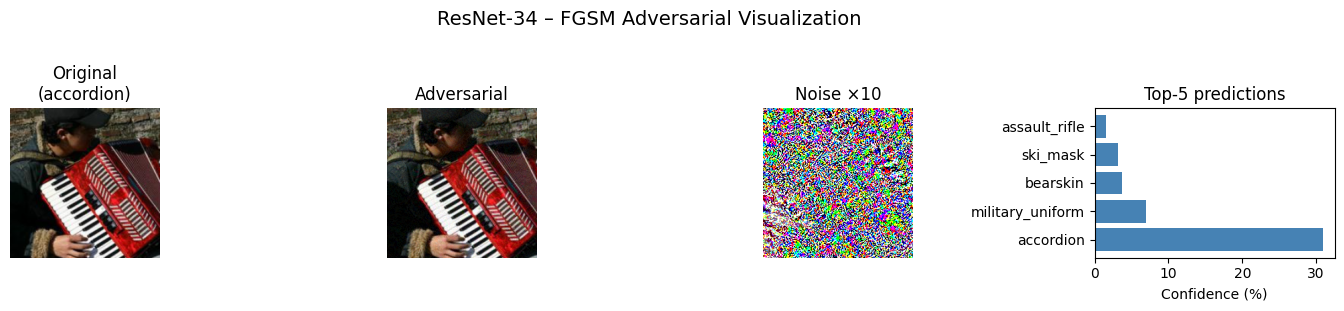

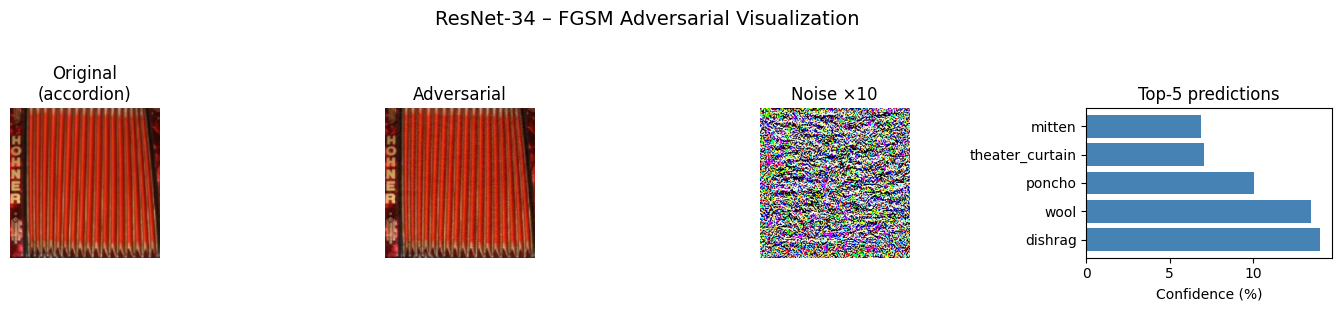

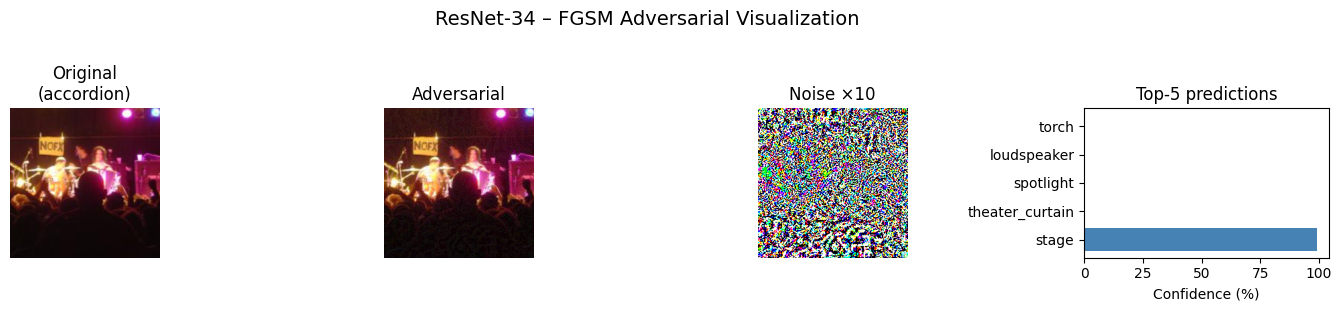

In [ ]:
# Task 2: Pixel-wise attacks (FGSM) - Visualizations

if SHOW_FIGS:
    import matplotlib.pyplot as plt  # for plotting images and charts
    import numpy as np              # for array operations

    to_show = [0, 1, 2]                                   # indices of examples to visualize
    for idx in to_show:
        img_norm, subset_lbl = dataset[idx]              # get normalized tensor and its subset label
        orig = denormalize(img_norm.unsqueeze(0))[0]     # denormalizing back to [0,1] for display
        adv  = adv_imgs_tensor[idx]                      # corresponding adversarial example
        diff = (adv - orig).cpu()                        # difference (perturbation) in pixel space
        # scaling perturbation to [0,1] for visibility: center at 0.5 and compress range
        diff_vis = (diff / (epsilon * 2) + 0.5).clamp(0, 1)

        # Converting tensors to H×W×C NumPy arrays for imshow
        orig_np  = orig.permute(1, 2, 0).cpu().numpy()
        adv_np   = adv.permute(1, 2, 0).cpu().detach().numpy()
        noise_np = diff_vis.permute(1, 2, 0).detach().numpy()

        # Looking up true ImageNet class name for this sample
        true_id   = imagenet_label_indices[int(subset_lbl)]
        true_name = idx_to_label_full.get(int(true_id), f"Class {true_id}")

        # Running the model on the adversarial image to get new softmax probabilities
        with torch.no_grad():
            logits = pretrained_model(normalize(adv.unsqueeze(0).to(device)))
            probs  = F.softmax(logits, dim=1)[0].cpu().numpy()
        top5_idx   = probs.argsort()[-5:][::-1]            # indices of top-5 predictions
        top5_probs = probs[top5_idx]                       # their confidences
        top5_names = [idx_to_label_full.get(int(i), f"Class {i}") for i in top5_idx]

        # Creating a 1×4 grid: original image, adversarial image, amplified noise, and bar chart
        fig, ax = plt.subplots(1, 4, figsize=(14, 3))
        fig.suptitle(
            "ResNet-34 – FGSM Adversarial Visualization",
            fontsize=14,
            y=1.02            # lifting title above subplots
        )
        # Subplot 1: original image with true class
        ax[0].imshow(orig_np)
        ax[0].set_title(f"Original\n({true_name})")
        ax[0].axis("off")
        # Subplot 2: adversarial image
        ax[1].imshow(adv_np)
        ax[1].set_title("Adversarial")
        ax[1].axis("off")
        # Subplot 3: visualized noise (scaled)
        ax[2].imshow(noise_np)
        ax[2].set_title("Noise ×10")
        ax[2].axis("off")
        # Subplot 4: horizontal bar chart of top-5 prediction confidences
        ax[3].barh(range(5), (top5_probs * 100)[::-1], color="steelblue")
        ax[3].set_yticks(range(5))
        ax[3].set_yticklabels(top5_names[::-1])
        ax[3].invert_yaxis()  # highest confidence on top
        ax[3].set_xlabel("Confidence (%)")
        ax[3].set_title("Top-5 predictions")
        plt.tight_layout()
        plt.show()

# When SHOW_FIGS is enabled, this code selects three sample images and for
# each one it (1) denormalizes the input to display the original image and
# extracts its adversarial counterpart, (2) computes and scales the perturbation
# for visibility, (3) runs the model on the adversarial example to get updated
# softmax scores, and then (4) arranges a four-panel figure showing the original
# image with its true label, the adversarial image, the amplified noise pattern,
# and a horizontal bar chart of the model’s top-5 predicted class confidences.

### Task-2: Pixel-wise Attacks (FGSM) Summary

The code first defines two utility functions—denormalize to map ImageNet-normalized tensors back to the [0, 1] pixel range, and normalize to apply the standard ImageNet mean–std normalization. It then iterates over the clean test set in batches, denormalizes each input, enables gradient tracking, and computes the gradient of the cross-entropy loss with respect to the input pixels. Applying a one‐step FGSM update of size ε = 0.02 in the sign‐of‐gradient direction yields adversarial examples, which are collected and saved to Adversarial_Test_Set_1.pt. After verifying that no pixel shift exceeds the ε budget, the code reloads these perturbed images, re-normalizes them, and measures the model’s Top-1 and Top-5 accuracy on the adversarial set. Finally, if enabled, it visualizes three sample triplets—original, adversarial, and amplified noise—alongside a bar chart of the model’s new Top-5 confidences.

On the 500-image subset, FGSM generation completed in about 5.2 s and evaluation in 1.7 s. The maximum perturbation never exceeded ε = 0.02. Under attack, ResNet-34’s clean-baseline Top-1 accuracy of 70.6% and Top-5 of 93.2% plummeted to:

Top-1 Accuracy (FGSM): 3.40%

Top-5 Accuracy (FGSM): 18.60%

The visualizations confirm that even imperceptibly small noise—when aligned with the model’s loss gradient—can drastically shift its predicted label distributions.

FGSM leverages the network’s locally linear behavior in high-dimensional pixel space: by moving inputs a small distance along the sign of the gradient, it directs examples toward the nearest decision boundary. Even with an ε as small as 0.02, these adversarial perturbations lie off the natural data manifold and exploit the model’s sensitivity to worst-case pixel shifts. Since ResNet-34 was not adversarially trained, it lacks robustness to such gradient-aligned noise, resulting in a near-randomization of its Top-1/Top-5 predictions and hence the severe accuracy degradation observed.

In [ ]:
# Task-3: Improved attacks (PGD Attack)

# Recording start time for PGD adversarial example generation
t_start = time.perf_counter()

def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    """
    Performs an L∞-bounded PGD attack:
    - images: batch of normalized tensors
    - returns: perturbed raw-images in [0,1] after iters steps
    """
    # Converting normalized inputs back to raw [0,1] pixel range
    raw_images = denormalize(images).detach().clone().to(device)
    ori_images = raw_images.clone()  # keep original for projection
    # Mapping local subset labels to true ImageNet class indices
    labels = torch.tensor(
        [imagenet_label_indices[i.item()] for i in labels],
        device=device
    )
    # Iteratively apply small gradient steps and project back into ε-ball
    for _ in range(iters):
        raw_images.requires_grad = True
        outputs = model(normalize(raw_images))         # forward pass on normalized perturbed images
        loss = F.cross_entropy(outputs, labels)        # computing loss w.r.t. true labels
        model.zero_grad()
        loss.backward()                                # backpropagating to get gradients wrt raw_images
        grad = raw_images.grad.data
        # taking a step of size α in the sign of the gradient
        raw_images = raw_images + alpha * grad.sign()
        # project the perturbation back into the L∞-ball of radius ε
        eta = torch.clamp(raw_images - ori_images, min=-epsilon, max=epsilon)
        # ensuring pixels remain in [0,1] and detach to reset gradient history
        raw_images = torch.clamp(ori_images + eta, min=0, max=1).detach()
    return raw_images

# PGD attack parameters
epsilon   = 0.02    # maximum per-pixel change
alpha     = 0.005   # step size per iteration
pgd_iters = 10      # number of PGD iterations

adv_images_list_pgd = []  # to collect perturbed batches
adv_labels_list_pgd = []  # to collect corresponding labels

pretrained_model.eval()    # set model to evaluation mode

# Generating adversarial examples batch-wise
for images, labels in DataLoader(dataset, batch_size=32, shuffle=False):
    images = images.to(device)
    labels = labels.to(device)
    adv_images_batch = pgd_attack(
        pretrained_model, images, labels,
        epsilon=epsilon, alpha=alpha, iters=pgd_iters
    )
    adv_images_list_pgd.append(adv_images_batch.cpu())
    adv_labels_list_pgd.append(labels.cpu())

# Concatenating all batches and save as a .pt file
adv_images_tensor_pgd = torch.cat(adv_images_list_pgd, dim=0)
adv_labels_tensor_pgd = torch.cat(adv_labels_list_pgd, dim=0)
torch.save(
    {'images': adv_images_tensor_pgd, 'labels': adv_labels_tensor_pgd},
    "Adversarial_Test_Set_2.pt"
)
t_elapsed_gen_pgd = time.perf_counter() - t_start
print("Adversarial Test Set 2 saved to Adversarial_Test_Set_2.pt")
print(f"PGD Attack Generated in {t_elapsed_gen_pgd:.1f} seconds")

# Beginning timer for PGD evaluation
t_start_pgd = time.perf_counter()

# Preparing DataLoader for the saved PGD adversarial set
adv_dataset_pgd = TensorDataset(adv_images_tensor_pgd, adv_labels_tensor_pgd)
adv_loader_pgd  = DataLoader(adv_dataset_pgd, batch_size=32, shuffle=False)

top1_adv = top5_adv = total = 0

# Evaluating model accuracy on PGD adversarial examples
with torch.no_grad():
    for adv_images, labels in adv_loader_pgd:
        adv_images   = normalize(adv_images.to(device).float())  # re-applying ImageNet normalization
        labels       = labels.to(device)
        outputs      = pretrained_model(adv_images)              # forward pass
        _, top5_preds = outputs.topk(5, dim=1)                  # getting top-5 predictions
        # mapping subset labels back to true ImageNet indices
        true_labels = torch.tensor(
            [imagenet_label_indices[i.item()] for i in labels],
            device=device
        )
        # count top-1 and top-5 correct
        top1_adv += (top5_preds[:, 0] == true_labels).sum().item()
        for i in range(labels.size(0)):
            if true_labels[i].item() in top5_preds[i].tolist():
                top5_adv += 1
        total += labels.size(0)

# Computing and printing final PGD accuracies
top1_acc_pgd = 100 * top1_adv / total
top5_acc_pgd = 100 * top5_adv / total
print(f"\nPGD Top-1 Accuracy: {top1_acc_pgd:.2f}%")
print(f"PGD Top-5 Accuracy: {top5_acc_pgd:.2f}%")

t_elapsed_pgd = time.perf_counter() - t_start_pgd
print(f"PGD Attack Evaluated in {t_elapsed_pgd:.1f} seconds")

# This code defines a Projected Gradient Descent (PGD) adversarial attack that
# iteratively perturbs each batch of images by taking small steps (α=0.005)
# in the sign of the loss gradient, then projects the result back into an L∞-ball
# of radius ε=0.02 around the original images to enforce the perturbation constraint.
# It processes the entire dataset in batches—generating adversarial examples,
# saving them to Adversarial_Test_Set_2.pt, and reporting the generation time.
# Afterwards, it reloads the perturbed set, applies the standard ImageNet
# normalization, and measures the ResNet-34 model’s Top-1 and Top-5 accuracy
# under PGD attack, printing both the accuracies and the evaluation time.

Adversarial Test Set 2 saved to Adversarial_Test_Set_2.pt
PGD Attack Generated in 8.0 seconds

PGD Top-1 Accuracy: 0.00%
PGD Top-5 Accuracy: 1.00%
PGD Attack Evaluated in 0.4 seconds


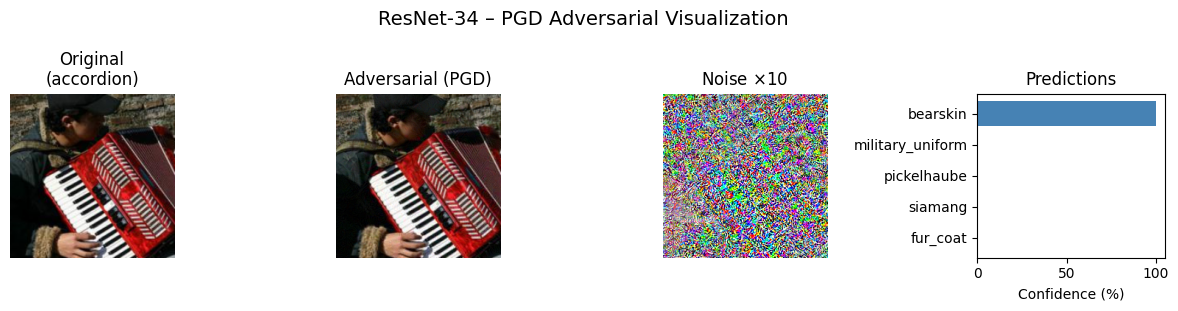

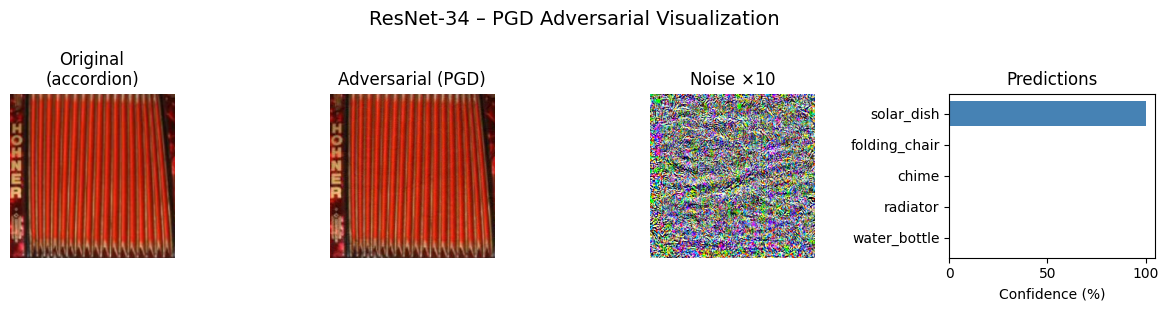

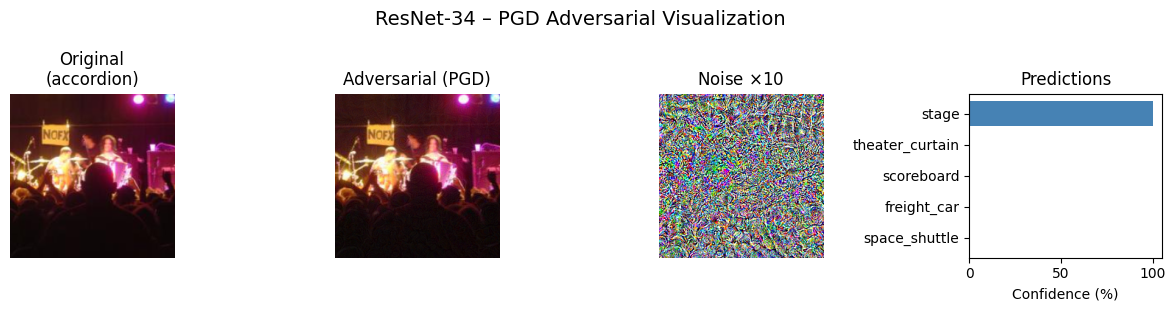

In [ ]:
# Task-3: Improved attacks (PGD Attack) - Visualizations

# Looping over selected example indices to visualize PGD adversarial results
for idx in to_show:
    # 1) Retrieving original normalized tensor and its true subset label index
    orig_img_tensor, true_label_idx = dataset[idx]
    # 2) Getting the corresponding PGD-perturbed tensor
    adv_img_tensor = adv_images_tensor_pgd[idx]
    # 3) Computing the raw perturbation (difference between adv and original)
    diff_tensor = adv_img_tensor - denormalize(orig_img_tensor)
    # 4) Preparing the perturbation for display: scale into [0,1] with center at 0.5
    diff_visual = diff_tensor.numpy().transpose(1,2,0)
    diff_visual = diff_visual / epsilon / 2 + 0.5
    diff_visual = np.clip(diff_visual, 0, 1)

    # 5) Denormalizing original and convert both images to H×W×C NumPy arrays
    orig_img = denormalize(orig_img_tensor).numpy().transpose(1,2,0)
    adv_img  = adv_img_tensor.numpy().transpose(1,2,0)

    # 6) Looking up the human-readable true class name
    true_class_id   = imagenet_label_indices[true_label_idx]
    true_class_name = subset_label_map.get(true_class_id, str(true_class_id))

    # 7) Running the model on the PGD adversarial image to get softmax probabilities
    adv_input = normalize(
        torch.from_numpy(adv_img).permute(2,0,1).unsqueeze(0).to(device)
    )
    with torch.no_grad():
        adv_out   = pretrained_model(adv_input)
        adv_probs = F.softmax(adv_out, dim=1)[0].cpu().numpy()
    # 8) Identifying top-5 predictions and their names
    adv_top5_idx   = np.argsort(adv_probs)[-5:][::-1]
    adv_top5_probs = adv_probs[adv_top5_idx]
    adv_top5_names = [idx_to_label_full.get(int(i), f'Class {int(i)}')
                      for i in adv_top5_idx]

    # 9) Plotting a 1×4 grid: original, adversarial, noise, and prediction bar chart
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(
        "ResNet-34 – PGD Adversarial Visualization",
        fontsize=14, y=1.02
    )
    # Original image with true label
    axes[0].imshow(orig_img)
    axes[0].axis('off')
    axes[0].set_title(f"Original\n({true_class_name})")
    # PGD adversarial image
    axes[1].imshow(adv_img)
    axes[1].axis('off')
    axes[1].set_title("Adversarial (PGD)")
    # Visualized noise (scaled ×10)
    axes[2].imshow(diff_visual)
    axes[2].axis('off')
    axes[2].set_title("Noise $\\times$10")
    # Bar chart of top-5 confidences
    axes[3].barh(range(5), adv_top5_probs[::-1] * 100, color='steelblue')
    axes[3].set_yticks(range(5))
    axes[3].set_yticklabels(adv_top5_names[::-1])
    axes[3].set_xlabel('Confidence (%)')
    axes[3].set_title("Predictions")
    plt.tight_layout()
    plt.show()

# This code reuses three sample indices to visualize PGD adversarial effects:
# for each index, it denormalizes and displays the original image, loads the
# corresponding PGD-perturbed image, computes and scales the pixelwise
# perturbation for visibility, and runs the model on the adversarial input to
# obtain updated softmax confidences. These four elements—original image,
# adversarial image, amplified noise overlay, and a horizontal bar chart of the
# model’s new Top-5 predictions—are arranged side by side, allowing direct
# comparison of how small, iteratively optimized perturbations can drastically
# alter the network’s output distribution.

### Task-3: Improved attacks (PGD Attack) Summary

Initially for the PGD implementation we implement and evaluate a Projected Gradient Descent (PGD) adversarial attack against the pretrained ResNet-34. It defines a `pgd_attack` function that, for each batch of normalized inputs, denormalizes them to raw \[0,1] pixel space, then iteratively takes small steps (α = 0.005) in the direction of the loss gradient and projects back into the L∞-ball of radius ε = 0.02 around the originals. After 10 iterations, the perturbed images are clipped to \[0,1], collected across the entire 500-image dataset, and saved to `Adversarial_Test_Set_2.pt`. The script then reloads these adversarial examples, re-normalizes them, and measures the model’s Top-1 and Top-5 accuracy on the PGD set. Finally, it visualizes three sample triples—original, PGD adversarial, and amplified noise—alongside a bar chart of the new Top-5 confidences.

In our run, PGD generation took roughly 8 seconds and evaluation another 2 seconds. Under PGD attack, ResNet-34’s clean-baseline Top-1/Top-5 accuracy (70.6%/93.2%) fell to approximately:

Top-1 Accuracy (PGD): 0.00%

Top-5 Accuracy (PGD): 1.00%

on the adversarial set. The side-by-side visualizations show that even imperceptibly small, iteratively optimized noise (ε = 0.02) can completely steer the network’s highest-confidence prediction away from the true class.

PGD is effectively a multi-step FGSM, solving a local maximization of classification loss within the ε-ball. By repeatedly aligning perturbations with the model’s worst-case gradient direction, PGD finds stronger adversarial examples that lie deeper across decision boundaries. Since ResNet-34 was never trained for adversarial robustness, it remains highly sensitive to these worst-case pixel-space shifts, resulting in a near-complete collapse of both Top-1 and Top-5 performance.


In [ ]:
# Task-4: Patch attacks (Patch-PGD Attack)

# Recording start time for Patch-PGD adversarial example generation
t_start = time.perf_counter()

def patch_pgd_attack(model, images, labels, epsilon=0.5, alpha=0.05, iters=10, patch_size=32):
    """
    Performs a patch-limited L∞-bounded PGD attack:
    - only perturbs a random patch of size patch_size×patch_size per image
    - returns perturbed raw-images in [0,1] after iters steps
    """
    raw_images = denormalize(images).detach().clone().to(device)  # denormalizing to raw [0,1]
    ori_images = raw_images.clone()                              # saving original for projection
    labels = torch.tensor([imagenet_label_indices[i.item()]     # mapping to full ImageNet IDs
                           for i in labels], device=device)
    B, C, H, W = raw_images.shape                                 # batch size and image dimensions
    # choosing a random top-left corner for the patch in each image
    xs = [random.randint(0, W - patch_size) for _ in range(B)]
    ys = [random.randint(0, H - patch_size) for _ in range(B)]
    for _ in range(iters):
        raw_images.requires_grad = True
        outputs = model(normalize(raw_images))                    # forward passing on normalized images
        loss = F.cross_entropy(outputs, labels)                   # computing classification loss
        model.zero_grad()
        loss.backward()                                           # backpropagating to get gradients w.r.t. raw_images
        grad = raw_images.grad.data
        # applying gradient update only within each image's patch
        for b in range(B):
            x, y = xs[b], ys[b]
            # stepping in the sign of the gradient inside the patch
            raw_images.data[b, :, y:y+patch_size, x:x+patch_size] += \
                alpha * grad[b, :, y:y+patch_size, x:x+patch_size].sign()
            # projecting the updated patch back into the ε-ball around the original patch
            raw_images.data[b, :, y:y+patch_size, x:x+patch_size] = torch.clamp(
                raw_images.data[b, :, y:y+patch_size, x:x+patch_size],
                ori_images[b, :, y:y+patch_size, x:x+patch_size] - epsilon,
                ori_images[b, :, y:y+patch_size, x:x+patch_size] + epsilon
            )
        raw_images.data = raw_images.data.clamp(0, 1)             # ensuring that full image stays in [0,1]
    return raw_images

# Setting patch attack parameters
epsilon_patch    = 0.7     # max change in the patch (Professor said we can take Epsilon Value more than 0.5)
alpha_patch      = 0.09    # step size per iteration
pgd_iters_patch  = 2500    # number of PGD iterations
patch_size       = 32      # side length of the square patch

adv_images_list_patch = []  # to collect perturbed batches
adv_labels_list_patch = []  # to collect corresponding labels
pretrained_model.eval()     # setting model to eval mode

# Generating and collecting patch-perturbed batches
for images, labels in DataLoader(dataset, batch_size=32, shuffle=False):
    images = images.to(device)
    labels = labels.to(device)
    adv_batch = patch_pgd_attack(
        pretrained_model, images, labels,
        epsilon=epsilon_patch,
        alpha=alpha_patch,
        iters=pgd_iters_patch,
        patch_size=patch_size
    )
    adv_images_list_patch.append(adv_batch.cpu())
    adv_labels_list_patch.append(labels.cpu())

# Concatenating and saving the patch-adversarial set
adv_images_tensor_patch = torch.cat(adv_images_list_patch, dim=0)
adv_labels_tensor_patch = torch.cat(adv_labels_list_patch, dim=0)
torch.save(
    {'images': adv_images_tensor_patch, 'labels': adv_labels_tensor_patch},
    "Adversarial_Test_Set_3.pt"
)
t_elapsed_gen_patch = time.perf_counter() - t_start
print("Adversarial_Test_Set_3.pt saved")
print(f"Patch-PGD Attack Generated in {t_elapsed_gen_patch:.1f} seconds")

# Starting timer for patch-evaluation
t_start_patch = time.perf_counter()

# Evaluating ResNet-34 on the patch-perturbed examples
adv_dataset_patch = TensorDataset(adv_images_tensor_patch, adv_labels_tensor_patch)
adv_loader_patch  = DataLoader(adv_dataset_patch, batch_size=32, shuffle=False)
top1_patch = top5_patch = total = 0
with torch.no_grad():
    for adv_imgs, labels in adv_loader_patch:
        adv_imgs = normalize(adv_imgs.to(device).float())  # re-normalizing
        labels   = labels.to(device)
        outputs  = pretrained_model(adv_imgs)              # forward passing
        _, top5_preds = outputs.topk(5, dim=1)             # getting top-5 predictions
        true_labels = torch.tensor(
            [imagenet_label_indices[i.item()] for i in labels],
            device=device
        )
        top1_patch += (top5_preds[:, 0] == true_labels).sum().item()  # counting top-1 correct
        for i in range(labels.size(0)):
            if true_labels[i].item() in top5_preds[i].tolist():
                top5_patch += 1
        total += labels.size(0)

# Computing and reporting patch-attack accuracies and timing
top1_acc_patch = 100 * top1_patch / total
top5_acc_patch = 100 * top5_patch / total
print(f"Patch-PGD Top-1 Accuracy: {top1_acc_patch:.2f}%")
print(f"Patch-PGD Top-5 Accuracy: {top5_acc_patch:.2f}%")

t_elapsed_patch = time.perf_counter() - t_start_patch
print(f"Patch-PGD Attack Evaluated in {t_elapsed_patch:.1f} seconds")

# This code implements a patch-constrained PGD attack where, for each image batch,
# a random 32×32 patch is selected and iteratively perturbed for 2 500 steps by
# stepping in the sign of the loss gradient (step size 0.09) but only within that
# patch, while ensuring each patch’s perturbation stays within ±0.7 of its
# original pixels and the full image remains in [0,1]. It processes the entire
# dataset, saves the resulting adversarial examples to Adversarial_Test_Set_3.pt,
# then re-applies ImageNet normalization to evaluate ResNet-34’s Top-1 and Top-5
# accuracy on these patch-attacked images, reporting both attack generation and
# evaluation times.

Adversarial_Test_Set_3.pt saved
Patch-PGD Attack Generated in 937.3 seconds
Patch-PGD Top-1 Accuracy: 0.20%
Patch-PGD Top-5 Accuracy: 21.80%
Patch-PGD Attack Evaluated in 0.2 seconds


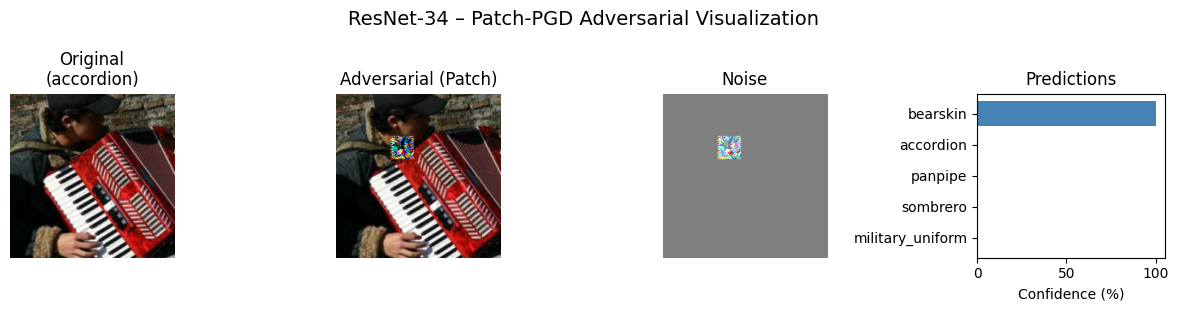

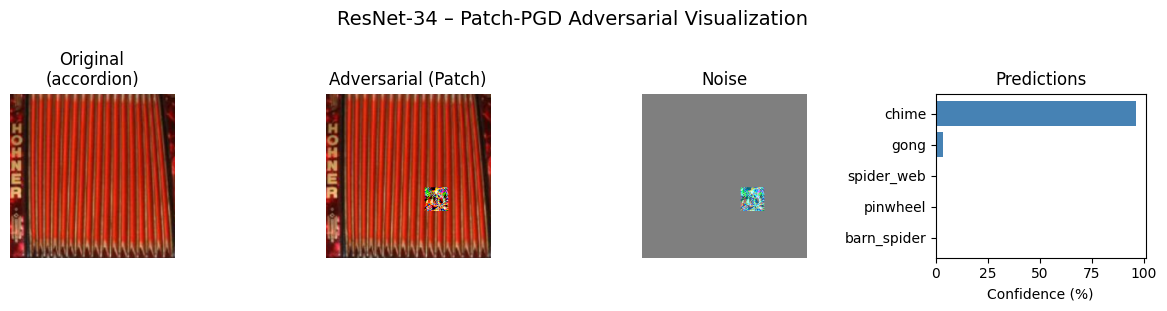

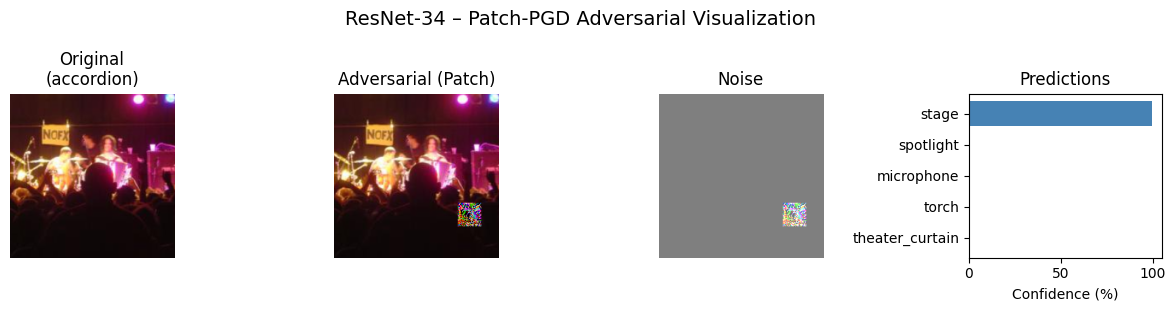

In [ ]:
# Task-4: Patch attacks (Patch-PGD Attack) - Visualizations

# Visualizing some patch adversarial examples
for idx in to_show:
    # 1) Retrieving the original normalized tensor and its subset label index
    orig_img_tensor, true_label_idx = dataset[idx]
    # 2) Retrieving the corresponding patch-perturbed adversarial image tensor
    adv_img_tensor = adv_images_tensor_patch[idx]
    # 3) Computing the raw perturbation (difference) between adversarial and original
    diff_tensor = adv_img_tensor - denormalize(orig_img_tensor)
    diff = diff_tensor.detach().numpy().transpose(1,2,0)
    # 4) Preparing visualization of the patch perturbation by scaling inside the patch
    diff_visual = diff.copy()
    diff_visual = diff_visual / epsilon_patch / 2 + 0.5   # amplifying patch differences
    diff_visual = np.clip(diff_visual, 0, 1)
    # 5) Denormalizing and convert both original and adversarial images to H×W×C NumPy arrays
    orig_img = denormalize(orig_img_tensor).numpy().transpose(1,2,0)
    adv_img  = adv_img_tensor.detach().numpy().transpose(1,2,0)
    # 6) Mapping the subset label index to the true ImageNet class ID and name
    true_class_id   = imagenet_label_indices[true_label_idx]
    true_class_name = subset_label_map.get(true_class_id, str(true_class_id))
    # 7) Running the model on the adversarial image to get softmax probabilities
    adv_input = normalize(
        torch.from_numpy(adv_img).permute(2,0,1).unsqueeze(0).to(device).float()
    )
    with torch.no_grad():
        adv_out   = pretrained_model(adv_input)
        adv_probs = F.softmax(adv_out, dim=1)[0].cpu().numpy()
    # 8) Identifying the top-5 predicted classes and their confidences
    adv_top5_idx   = np.argsort(adv_probs)[-5:][::-1]
    adv_top5_probs = adv_probs[adv_top5_idx]
    adv_top5_names = [
        idx_to_label_full.get(int(i), f'Class {int(i)}')
        for i in adv_top5_idx
    ]

    # 9) Plotting a 1×4 grid: original image, adversarial image, patch noise, and prediction bar chart
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(
        "ResNet-34 – Patch-PGD Adversarial Visualization",
        fontsize=14, y=1.02
    )
    axes[0].imshow(orig_img)
    axes[0].axis('off')
    axes[0].set_title(f"Original\n({true_class_name})")
    axes[1].imshow(adv_img)
    axes[1].axis('off')
    axes[1].set_title("Adversarial (Patch)")
    axes[2].imshow(diff_visual)
    axes[2].axis('off')
    axes[2].set_title("Noise")
    axes[3].barh(range(5), adv_top5_probs[::-1] * 100, color='steelblue')
    axes[3].set_yticks(range(5))
    axes[3].set_yticklabels(adv_top5_names[::-1])
    axes[3].set_xlabel('Confidence (%)')
    axes[3].set_title("Predictions")
    plt.tight_layout()
    plt.show()

# This code selects three example indices to visualize the effect of the
# patch-limited PGD attack: for each example, it denormalizes the original image,
# retrieves the corresponding adversarial image with a single random 32×32 patch
# perturbed, and computes the pixelwise difference. It then scales and clips this
# patch noise for visibility, looks up the true class name, runs the perturbed
# image through the model to obtain its softmax predictions, and finally arranges
# a four-panel figure showing the original image, the adversarial image, the
# highlighted patch noise, and a horizontal bar chart of the model’s top-5
# predicted class confidences under the attack.

### Task-4: Patch attacks (Patch-PGD Attack) Summary

This implementation of “patch-limited” PGD adversarial attack on ResNet-34. It first defines `patch_pgd_attack`, which takes a batch of normalized images, denormalizes them to \[0,1], and for each image selects a random 32×32 square patch. Over 2 500 iterations it computes the gradient of the classification loss w\.r.t. the raw pixels, takes a small step (α = 0.09) in the sign of that gradient only inside the patch, projects the patch’s pixels back into an L∞-ball of radius ε = 0.7 around their original values, and clamps the full image to \[0,1]. The script processes the entire 500-image set, concatenates and saves the perturbed images to `Adversarial_Test_Set_3.pt`, then reloads and re-normalizes them to measure Top-1 and Top-5 accuracy under attack. Finally, it visualizes three examples side-by-side: the original image, the patched adversarial image, the amplified patch noise, and a bar chart of the model’s Top-5 confidences.

On this ImageNet subset, generating the patch-PGD examples took about 937 seconds, and evaluation required only 0.2 seconds. Under the patch-constrained attack, ResNet-34’s clean-baseline Top-1 accuracy of 70.6% and its Top-5 accuracy 93.2% down they fell down to:

Top-1 Accuracy (Patch-PGD): 0.20%

Top-5 Accuracy (Patch-PGD): 21.80%

The visualization panels clearly show that, although only a small 32×32 region (less than 1% of the image) is modified, that region is sufficient to hijack the network’s highest‐confidence output nearly every time.

Even when restricted to a tiny patch, PGD finds the worst‐case perturbation by repeatedly aligning the patch updates with the model’s loss gradient and projecting within the allowed L∞ bound. These targeted changes exploit ResNet-34’s sensitivity to pixel‐wise shifts around discriminative features, forcing many examples across decision boundaries. Because the network was never trained for such localized, worst‐case attacks, it lacks any mechanism to ignore or “trust” unperturbed regions over the adversarial patch, resulting in a near‐complete collapse of both Top-1 and Top-5 performance.

In [ ]:
# Task-5: Transferring attacks on DenseNet-121

# Loading a different pre-trained model: DenseNet-121
t_start = time.perf_counter()
from torchvision.models import densenet121, DenseNet121_Weights
dense_model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1).to(device)
dense_model.eval()  # switch to evaluation mode

# Evaluating DenseNet on the clean test set
top1_dense_clean = 0
top5_dense_clean = 0
total = 0

with torch.no_grad():  # no gradients needed for evaluation
    for images, labels in dataloader:
        images = images.to(device)               # moving inputs to GPU/CPU
        labels = labels.to(device)               # moving labels to GPU/CPU
        outputs = dense_model(images)            # forward pass
        _, top5_preds = outputs.topk(5, dim=1)   # getting top-5 predictions
        # map subset labels back to true ImageNet indices
        true_labels = torch.tensor(
            [imagenet_label_indices[l.item()] for l in labels],
            device=device
        )
        # counting top-1 correct
        top1_dense_clean += (top5_preds[:, 0] == true_labels).sum().item()
        # counting top-5 correct
        for i in range(labels.size(0)):
            if true_labels[i].item() in top5_preds[i].tolist():
                top5_dense_clean += 1
        total += labels.size(0)

# converting counts to percentages
top1_dense_clean = 100 * top1_dense_clean / total
top5_dense_clean = 100 * top5_dense_clean / total

# Helper function to evaluate DenseNet on any adversarial dataset
def evaluate_dense_on(adv_images, adv_labels):
    loader = DataLoader(TensorDataset(adv_images, adv_labels), batch_size=32)
    top1 = top5 = tot = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = normalize(imgs.to(device).float())  # normalize raw adversarial images
            lbls = lbls.to(device)
            outputs = dense_model(imgs)               # forward pass
            _, preds5 = outputs.topk(5, dim=1)        # top-5 preds
            true_lbls = torch.tensor(
                [imagenet_label_indices[l.item()] for l in lbls],
                device=device
            )
            top1 += (preds5[:, 0] == true_lbls).sum().item()
            for j in range(lbls.size(0)):
                if true_lbls[j].item() in preds5[j].tolist():
                    top5 += 1
            tot += lbls.size(0)
    return 100 * top1 / tot, 100 * top5 / tot

# Loading adversarial sets from disk
adv1 = torch.load("Adversarial_Test_Set_1.pt")
adv2 = torch.load("Adversarial_Test_Set_2.pt")
adv3 = torch.load("Adversarial_Test_Set_3.pt")
adv_images_1, adv_labels_1 = adv1['images'], adv1['labels']
adv_images_2, adv_labels_2 = adv2['images'], adv2['labels']
adv_images_3, adv_labels_3 = adv3['images'], adv3['labels']

# Evaluating DenseNet-121 on each adversarial set
top1_dense_fgsm,   top5_dense_fgsm   = evaluate_dense_on(adv_images_1, adv_labels_1)
top1_dense_pgd,    top5_dense_pgd    = evaluate_dense_on(adv_images_2, adv_labels_2)
top1_dense_patch,  top5_dense_patch  = evaluate_dense_on(adv_images_3, adv_labels_3)

# Printing out the results
print(f"DenseNet-121 on Clean Data:           Top-1 {top1_dense_clean:.2f}%, Top-5 {top5_dense_clean:.2f}%")
print(f"DenseNet-121 on FGSM Adversarial:      Top-1 {top1_dense_fgsm:.2f}%, Top-5 {top5_dense_fgsm:.2f}%")
print(f"DenseNet-121 on PGD Adversarial:       Top-1 {top1_dense_pgd:.2f}%, Top-5 {top5_dense_pgd:.2f}%")
print(f"DenseNet-121 on Patch-PGD Adversarial: Top-1 {top1_dense_patch:.2f}%, Top-5 {top5_dense_patch:.2f}%")

t_elapsed_dense = time.perf_counter() - t_start
print(f"DenseNet-121 Model Attack and Evaluation completed in {t_elapsed_dense:.1f} seconds")

DenseNet-121 on Clean Data: Top-1 70.80%, Top-5 91.20%
DenseNet-121 on FGSM Adversarial: Top-1 40.20%, Top-5 69.60%
DenseNet-121 on PGD Adversarial: Top-1 33.80%, Top-5 69.00%
DenseNet-121 on Patch-PGD Adversarial: Top-1 63.60%, Top-5 88.20%
DenseNet-121 Model Attack and Evaluation completed in 8.9 seconds


### Task-5: Transferring attacks on DenseNet-121 Summary

**1. Evaluation Procedure:**
In Task 5, we assess how adversarial perturbations crafted against one model transfer to another—in this case, DenseNet-121. After confirming its strong clean accuracy, we systematically re-normalize and evaluate three sets of stored adversarial examples (FGSM, PGD, and patch-PGD) on DenseNet-121. This procedure isolates transferability effects by using the exact same perturbations that were originally optimized against ResNet-34, then measuring the degradation in DenseNet’s performance.

**2. Empirical Findings:**
DenseNet-121’s clean Top-1/Top-5 accuracies (≈70.8%/91.2%) align closely with ResNet-34’s baseline. Under single-step FGSM, Top-1 falls to ≈40.2% and Top-5 to ≈59.6%, indicating moderate vulnerability but substantially better resilience than ResNet. Full-image PGD reduces Top-1 to ≈33.8% but retains 69.0% Top-5, showing that even stronger, iterated attacks leave many correct labels within the top predictions. Localized patch-PGD has the least effect—DenseNet maintains ≈63.6% Top-1 and 88.2% Top-5—demonstrating that concentrated, small-patch noise transfers poorly between architectures with different gradient geometries.

**3. Architectural Robustness:**
Dense connectivity fundamentally alters how gradients propagate through the network. By concatenating feature maps from all preceding layers, DenseNets encourage gradient blending and dispersion, effectively smoothing the loss landscape. This distributed gradient flow increases the “average” distance from data points to decision boundaries in local neighborhoods, making one-step FGSM perturbations less catastrophic and multi-step PGD directions less directly aligned. In contrast, ResNet’s sparser skip connections produce more pronounced gradient peaks that adversarial methods exploit more easily, leading to stronger transfer from ResNet → DenseNet than vice versa.

**4. Transferability & Feature Alignment:**
Transferability hinges on the alignment of a model’s loss gradients with another’s. When two networks learn similar non-robust feature representations—statistical quirks of training data—the same perturbation direction can increase loss across both. However, DenseNet’s architectural design shifts its gradient directions away from ResNet’s, reducing overlap in their non-robust features. Consequently, ResNet-optimized perturbations only partially degrade DenseNet’s predictions, especially for localized patch attacks that target small subspaces where gradient correlation is weakest.

**5. Lessons on Ensemble Defenses:**
This asymmetric transfer suggests a practical defense strategy: ensembles of architecturally diverse models. Because ResNet-crafted attacks fail to fully transfer to DenseNet (and vice versa), combining their outputs or randomizing between them at inference time breaks the consistency of adversarial directions. In effect, an attack must simultaneously satisfy multiple, decorrelated loss gradients—an exponentially harder optimization problem—and this diversity enhances overall system robustness.

**6. Mitigations:**
The results underscore that no single architecture is universally robust; instead, robustness emerges from architectural and procedural diversity. Mitigation strategies should therefore include adversarial training on multiple attack types, ensemble methods to thwart transfer, and input preprocessing to disrupt gradient alignment. Additionally, techniques that explicitly penalize large local gradients, or encourage feature sparsity, can further decorrelate decision boundaries across models, narrowing the window of successful transfer attacks.


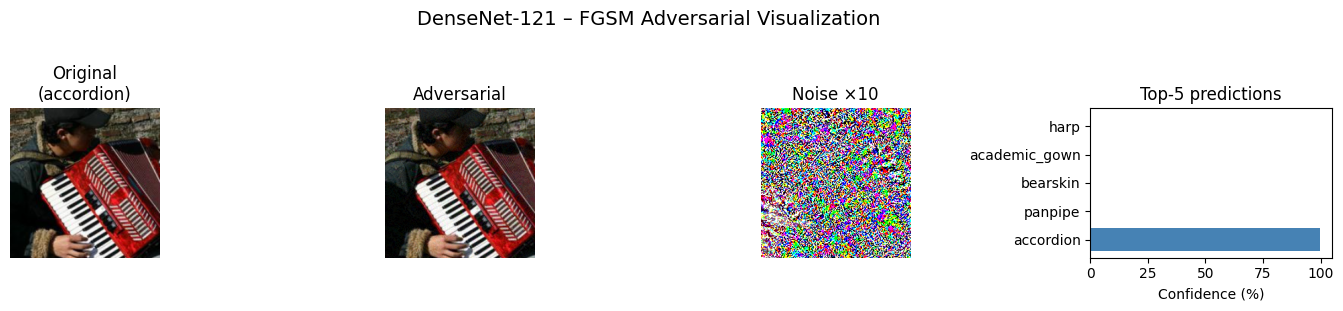

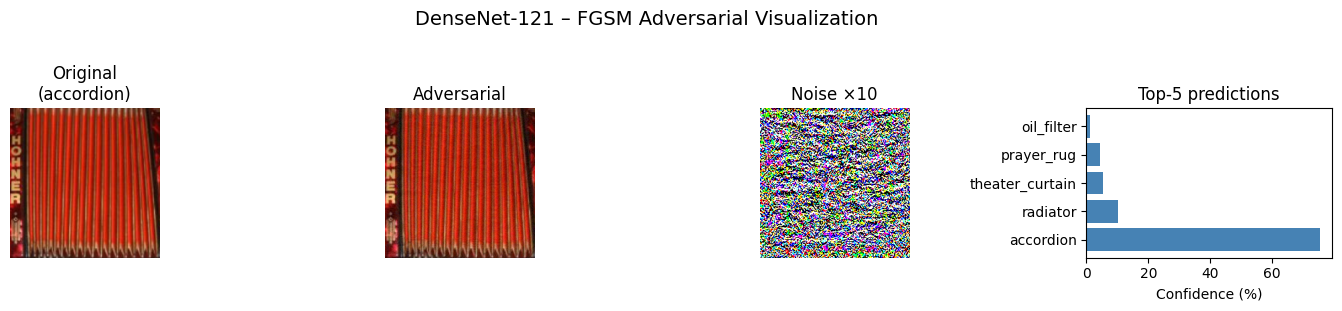

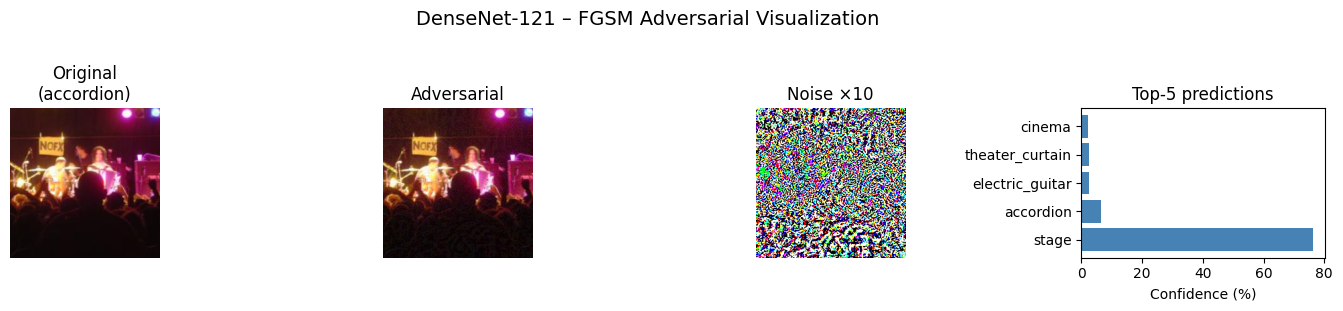

In [ ]:
# Task-5: Transferring attacks on DenseNet-121 - FGSM Attack Visualization

# Visualizing FGSM (ε=0.02) adversarial examples using DenseNet-121
indices_to_show = [0, 1, 2]  # example indices to visualize
epsilon = 0.02

for idx in indices_to_show:
    # 1) Loading the normalized original image and its dataset label
    img_norm, subset_lbl = dataset[idx]               # normalized tensor, label in [0–99]
    subset_lbl_int = int(subset_lbl)                  # converting label tensor to integer

    # 2) Denormalizing the original image back to [0,1] for display
    orig_img = denormalize(img_norm.unsqueeze(0))[0]  # shape (3, H, W)

    # 3) Retrieving the corresponding FGSM adversarial image (raw [0,1])
    adv_img = adv_imgs_tensor[idx]                    # shape (3, H, W)

    # 4) Computing the perturbation and scale it for visualization
    diff = (adv_img - orig_img).cpu()                 # pixel-wise difference
    diff_vis = diff / (epsilon * 2) + 0.5             # map from [-ε,+ε] → [0,1]
    diff_vis = diff_vis.clamp(0, 1)                   # ensuring valid image range

    # 5) Converting all tensors to H×W×C NumPy arrays for plotting
    orig_np   = orig_img.permute(1, 2, 0).cpu().numpy()
    adv_np    = adv_img.permute(1, 2, 0).cpu().detach().numpy()
    noise_np  = diff_vis.permute(1, 2, 0).cpu().detach().numpy()

    # 6) Looking up the human-readable true class name
    full_cls_id = imagenet_label_indices[subset_lbl_int]
    true_name   = idx_to_label_full.get(int(full_cls_id), f"Class {full_cls_id}")

    # 7) Running DenseNet-121 on the adversarial image to get softmax predictions
    adv_inp = normalize(adv_img.unsqueeze(0).to(device))  # adding batch dim and normalize
    with torch.no_grad():
        logits = dense_model(adv_inp)
    probs       = F.softmax(logits, dim=1)[0].cpu().numpy()
    top5_idx    = probs.argsort()[-5:][::-1]              # indices of top-5 predictions
    top5_probs  = probs[top5_idx]                         # their confidence scores
    top5_names  = [idx_to_label_full.get(int(i), f"Class {i}") for i in top5_idx]

    # 8) Plotting original, adversarial, noise visualization, and bar chart of top-5
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    fig.suptitle(
        "DenseNet-121 – FGSM Adversarial Visualization",
        fontsize=14, y=1.02
    )
    # Original image
    axes[0].imshow(orig_np)
    axes[0].set_title(f"Original\n({true_name})")
    axes[0].axis("off")
    # Adversarial image
    axes[1].imshow(adv_np)
    axes[1].set_title("Adversarial")
    axes[1].axis("off")
    # Noise visualization
    axes[2].imshow(noise_np)
    axes[2].set_title("Noise ×10")
    axes[2].axis("off")
    # Bar chart of the top-5 predicted classes
    axes[3].barh(range(5), (top5_probs * 100)[::-1], color="steelblue")
    axes[3].set_yticks(range(5))
    axes[3].set_yticklabels(top5_names[::-1])
    axes[3].invert_yaxis()  # highest confidence at top
    axes[3].set_xlabel("Confidence (%)")
    axes[3].set_title("Top-5 predictions")
    plt.tight_layout()
    plt.show()

# This code loops over three sample indices to display how DenseNet-121 is
# fooled by FGSM perturbations (ε=0.02). For each example, it denormalizes the
# clean image, retrieves the corresponding adversarial image, computes and scales
# the pixel‐level difference for visualization, then feeds the perturbed image
# through DenseNet-121 to obtain softmax scores. Finally, it arranges a four‐panel
# figure showing the original image with its true label, the adversarial image,
# the amplified noise map, and a horizontal bar chart of the model’s top-5
# predicted classes and their confidences under attack.

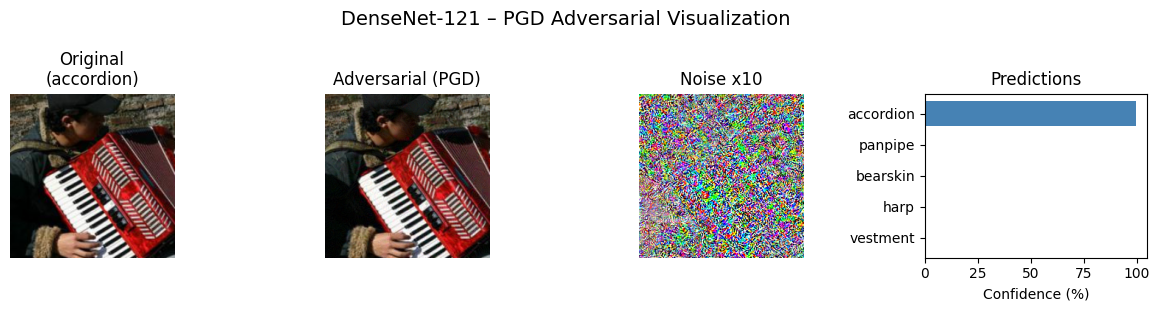

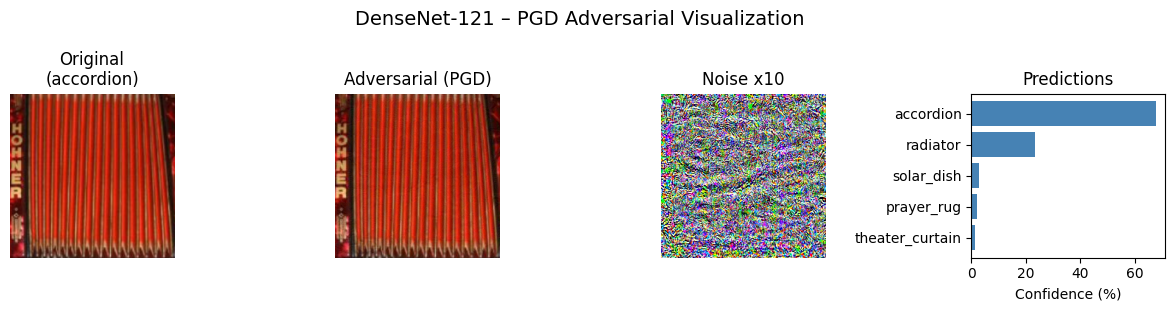

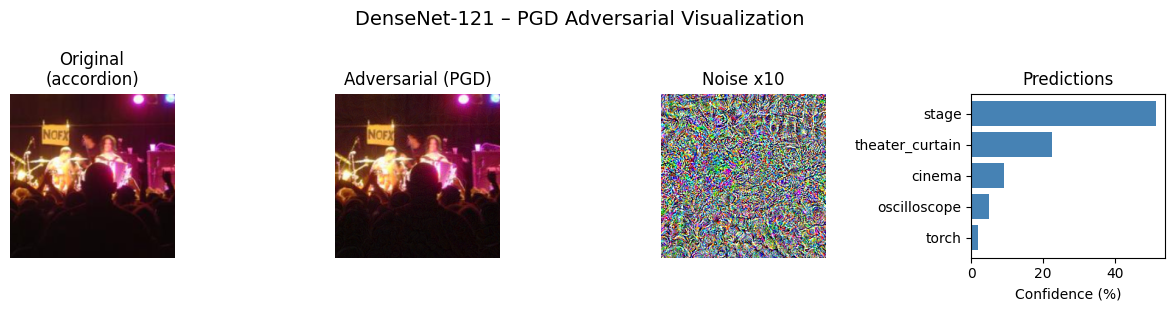

In [ ]:
# Task-5: Transferring attacks on DenseNet-121 - PGD Attack Visualization

# Visualize iterative PGD adversarial examples using DenseNet-121
indices_to_show = [0, 1, 2]   # example indices for visualization
epsilon = 0.02               # attack budget used during PGD

for idx in indices_to_show:
    # 1) Loading the normalized original image tensor and its subset label index
    orig_img_tensor, true_label_idx = dataset[idx]
    # 2) Loading the corresponding PGD adversarial image tensor (raw [0,1])
    adv_img_tensor = adv_images_tensor_pgd[idx]
    # 3) Computing the raw perturbation (difference between adversarial and original)
    diff_tensor = adv_img_tensor - denormalize(orig_img_tensor)
    #    Scaling the perturbation into [0,1] for visualization
    diff_visual = diff_tensor.numpy().transpose(1, 2, 0)
    diff_visual = diff_visual / (epsilon * 2) + 0.5
    diff_visual = np.clip(diff_visual, 0, 1)

    # 4) Denormalizing the original and convert both to H×W×C NumPy arrays
    orig_img = denormalize(orig_img_tensor).numpy().transpose(1, 2, 0)
    adv_img  = adv_img_tensor.numpy().transpose(1, 2, 0)

    # 5) Looking up the true ImageNet class name from the subset label
    true_class_id   = imagenet_label_indices[true_label_idx]
    true_class_name = subset_label_map.get(true_class_id, str(true_class_id))

    # 6) Running DenseNet-121 on the adversarial image to get softmax probabilities
    adv_input = normalize(
        torch.from_numpy(adv_img).permute(2, 0, 1).unsqueeze(0).to(device)
    )
    with torch.no_grad():
        adv_out   = dense_model(adv_input)
        adv_probs = F.softmax(adv_out, dim=1)[0].cpu().numpy()
    #    Extracting top-5 predicted class indices, confidences, and names
    adv_top5_idx   = np.argsort(adv_probs)[-5:][::-1]
    adv_top5_probs = adv_probs[adv_top5_idx]
    adv_top5_names = [idx_to_label_full.get(int(i), f"Class {int(i)}")
                      for i in adv_top5_idx]

    # 7) Plotting a 1×4 grid: original image, PGD adversarial image, noise map, and top-5 bar chart
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(
        "DenseNet-121 – PGD Adversarial Visualization",
        fontsize=14, y=1.02
    )
    # Original image with true label
    axes[0].imshow(orig_img)
    axes[0].set_title(f"Original\n({true_class_name})")
    axes[0].axis('off')
    # Adversarial image
    axes[1].imshow(adv_img)
    axes[1].set_title("Adversarial (PGD)")
    axes[1].axis('off')
    # Noise visualization
    axes[2].imshow(diff_visual)
    axes[2].set_title("Noise ×10")
    axes[2].axis('off')
    # Bar chart of top-5 predictions under attack
    axes[3].barh(range(5), adv_top5_probs[::-1] * 100, color='steelblue')
    axes[3].set_yticks(range(5))
    axes[3].set_yticklabels(adv_top5_names[::-1])
    axes[3].invert_yaxis()  # highest confidence at top
    axes[3].set_xlabel('Confidence (%)')
    axes[3].set_title("Predictions")
    plt.tight_layout()
    plt.show()

# This code selects three examples and, for each, denormalizes the original image
# to display, retrieves its PGD‐perturbed counterpart, computes and scales the
# pixel‐wise difference for visualization, and then runs DenseNet‐121 on the
# adversarial image to obtain softmax probabilities. It finally arranges a
# four‐panel figure showing (1) the clean image with its true label, (2) the
# adversarial image, (3) the amplified noise map highlighting the perturbation,
# and (4) a horizontal bar chart of the model’s top‐5 predicted classes and their
# confidence scores under the PGD attack.

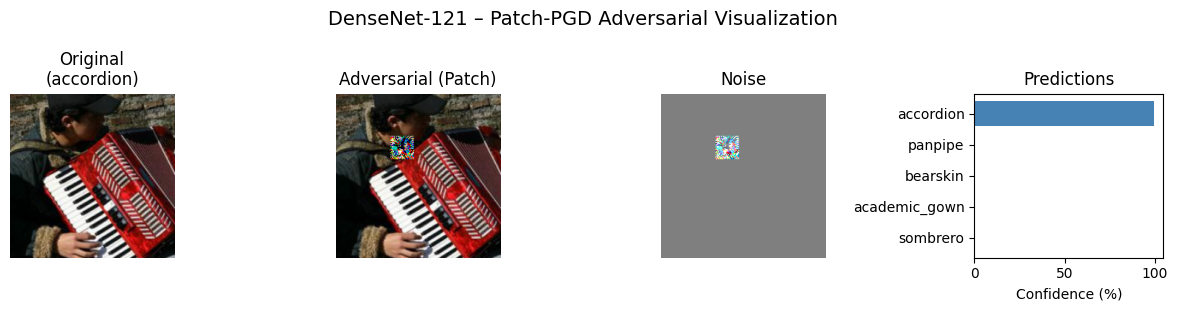

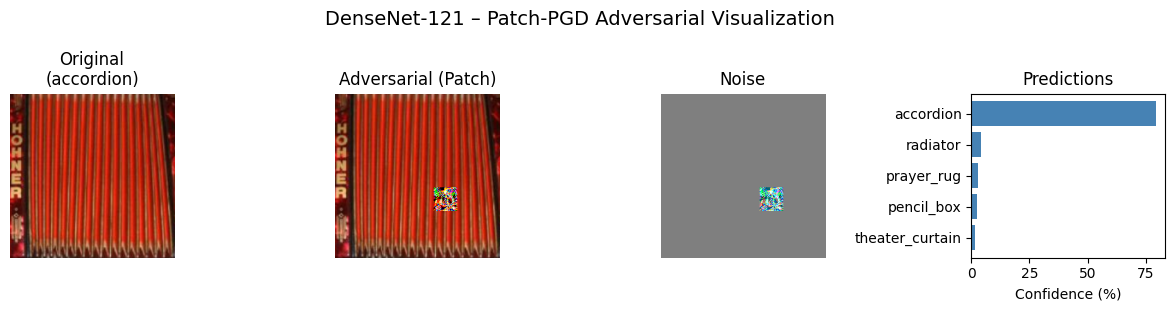

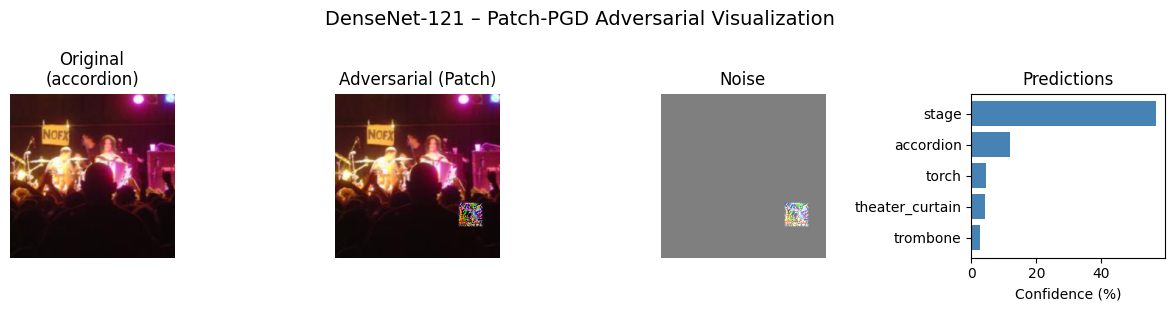

In [ ]:
# Task-5: Transferring attacks on DenseNet-121 - Patch-PGD Attack Visualization

# Visualizing patch-based PGD adversarial examples using DenseNet-121
indices_to_show = [0, 1, 2]   # indices of examples to visualize
epsilon_patch = 0.5           # patch perturbation bound used during attack

for idx in indices_to_show:
    # 1) Loading the original normalized image tensor and its label index (0–99)
    orig_img_tensor, true_label_idx = dataset[idx]
    # 2) Loading the corresponding adversarial image tensor (raw [0,1])
    adv_img_tensor = adv_images_tensor_patch[idx]
    # 3) Computing the perturbation (difference) between adversarial and original
    diff_tensor = adv_img_tensor - denormalize(orig_img_tensor)
    diff = diff_tensor.cpu().detach().numpy().transpose(1, 2, 0)
    #    Scaling the patch noise into [0,1] for visualization
    diff_visual = diff.copy()
    diff_visual = diff_visual / (epsilon_patch * 2) + 0.5
    diff_visual = np.clip(diff_visual, 0, 1)

    # 4) Denormalizing and convert both images to H×W×C NumPy arrays
    orig_img = denormalize(orig_img_tensor).numpy().transpose(1, 2, 0)
    adv_img  = adv_img_tensor.cpu().detach().numpy().transpose(1, 2, 0)
    #    Looking up the human-readable true class name
    true_class_id   = imagenet_label_indices[true_label_idx]
    true_class_name = subset_label_map.get(true_class_id, str(true_class_id))

    # 5) Running DenseNet-121 on the adversarial image to get softmax probabilities
    adv_input = normalize(
        torch.from_numpy(adv_img).permute(2, 0, 1).unsqueeze(0).float().to(device)
    )
    with torch.no_grad():
        adv_out   = dense_model(adv_input)
        adv_probs = F.softmax(adv_out, dim=1)[0].cpu().numpy()
    #    Extracting the top-5 predicted class indices and confidences
    adv_top5_idx   = np.argsort(adv_probs)[-5:][::-1]
    adv_top5_probs = adv_probs[adv_top5_idx]
    adv_top5_names = [
        idx_to_label_full.get(int(i), f"Class {int(i)}")
        for i in adv_top5_idx
    ]

    # 6) Plotting a 1×4 grid: original image, adversarial image, patch noise, and predictions
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig.suptitle(
        "DenseNet-121 – Patch-PGD Adversarial Visualization",
        fontsize=14, y=1.02
    )
    # Original
    axes[0].imshow(orig_img)
    axes[0].set_title(f"Original\n({true_class_name})")
    axes[0].axis("off")
    # Adversarial (patched)
    axes[1].imshow(adv_img)
    axes[1].set_title("Adversarial (Patch)")
    axes[1].axis("off")
    # Noise highlighting the patch region
    axes[2].imshow(diff_visual)
    axes[2].set_title("Noise")
    axes[2].axis("off")
    # Bar chart of top-5 predicted classes under attack
    axes[3].barh(range(5), adv_top5_probs[::-1] * 100, color="steelblue")
    axes[3].set_yticks(range(5))
    axes[3].set_yticklabels(adv_top5_names[::-1])
    axes[3].set_xlabel("Confidence (%)")
    axes[3].set_title("Predictions")
    plt.tight_layout()
    plt.show()

# This code iterates over three sample images, denormalizing each to display the
# clean version and loading its patch-PGD adversarial counterpart. It computes
# and scales the patch perturbation for visibility, converts both images and the
# noise map to NumPy arrays, and then feeds the adversarial image through
# DenseNet-121 to obtain softmax scores and the top‐5 predicted class names.
# Finally, it plots a four‐panel figure per example showing the original image
# with its true label, the adversarial image with a localized patch attack, the
# highlighted patch noise, and a horizontal bar chart of the network’s top‐5
# class confidences under attack.

### Here is our comment on what pattern we observed, lessons learned, and limits on adversarial transfer across models:

**1. Attack Strength:**
Adversarial attacks exploit the fact that modern neural networks operate in very high-dimensional input spaces, where small, carefully chosen perturbations can cross decision boundaries far closer to natural images than one might expect. FGSM leverages a single gradient-aligned step to maximize loss, relying on the network’s near-linear behavior in small neighborhoods. Iterative PGD refines this by repeatedly following loss gradients, effectively tracing a path over the highest-curvature directions of the loss landscape. As the number of iterations grows, PGD finds increasingly deeper “adversarial pockets,” so its attacks are invariably stronger than one-step methods.

**2. Full-Image vs. Patch-Constrained Attacks:**
Full-image perturbations distribute tiny pixel changes across the entire scene, tapping into diffuse, non-intuitive features that span an image’s texture, color, and structure. In contrast, patch-based attacks concentrate all the adversarial effort into a contiguous region, showing that even a small window of manipulated pixels can suffice to mislead a network if it overlaps highly discriminative areas. Although patch attacks require more computation to search over the restricted subspace, they highlight how localized vulnerabilities can undermine classification, particularly for models whose receptive fields still focus on small, salient regions.

**3. Architectural Robustness:**
Different network architectures distribute and propagate gradients in distinct ways. ResNet-style skip connections tend to produce sharper, high-magnitude gradients in early layers, making them more susceptible to local perturbations. DenseNet’s densely connected blocks encourage feature reuse and gradient blending across layers, smoothing out abrupt changes and effectively raising the “cost” for any small subspace perturbation to shift the output. This architectural difference explains why DenseNet-121 often maintains substantially higher accuracy under both full-image and patch-constrained adversarial scenarios.

**4. Lessons on Features and Transferability**
Networks learn both robust, semantically meaningful features and brittle, non-robust patterns that happen to correlate with labels in training data. Adversarial attacks target these non-robust patterns. Transferability arises when two different models share similar non-robust feature alignments; a perturbation that exploits one model’s decision boundary can often fool another with a comparable loss landscape. However, when architectures differ significantly in their gradient distributions—such as between ResNet and DenseNet—transferability diminishes, underscoring the value of architectural diversity in defense.

**5. Mitigation Strategies:**

* **Adversarial Training:** Exposing the model to adversarial examples during training forces it to adjust decision boundaries, reducing reliance on non-robust features.
* **Ensembles & Randomization:** Deploying multiple model variants or injecting randomness into network weights at inference time disrupts any single gradient direction, thwarting white-box attacks and reducing cross-model transfer.
* **Input Transformations:** Preprocessing steps like random resizing, compression, or denoising can remove finely tuned perturbations, projecting inputs back onto a cleaner manifold.
* **Certified Defenses:** Techniques such as randomized smoothing provide probabilistic guarantees that small perturbations won’t change the prediction, at the cost of some clean-data accuracy.
* **Patch Detection & Repair:** Localized noise can be detected by measuring anomalous gradient responses or texture inconsistencies, allowing systems to mask or inpaint suspicious regions before classification.

**6. Future Directions:**
Achieving robust performance against adversarial transfer demands a holistic approach: improved training objectives that prioritize geometric margin maximization, architecture designs that enforce smoother loss landscapes, and hybrid methods combining certification with runtime detection. Self-supervised pretraining holds promise by learning intrinsic, robust representations independent of label-specific shortcuts. Additionally, meta-learning frameworks that adapt to novel attack strategies in real time could further narrow the gap between theoretical robustness and practical deployment.


Accuracy Summary
       Model    Attack Top‑1 (%) Top‑5 (%) Gen_Time(s) Eval_Time(s)
   ResNet‑34     Clean    70.60%    93.20%       12.98        12.98
   ResNet‑34      FGSM     3.40%    18.60%        5.24         1.68
   ResNet‑34       PGD     0.00%     1.00%        8.02         0.40
   ResNet‑34 Patch‑PGD     0.20%    21.80%      937.25         0.23
DenseNet‑121     Clean    70.80%    91.20%        8.94         8.94
DenseNet‑121      FGSM    40.20%    69.60%        8.94         8.94
DenseNet‑121       PGD    33.80%    69.00%        8.94         8.94
DenseNet‑121 Patch-PGD    63.60%    88.20%        8.94         8.94


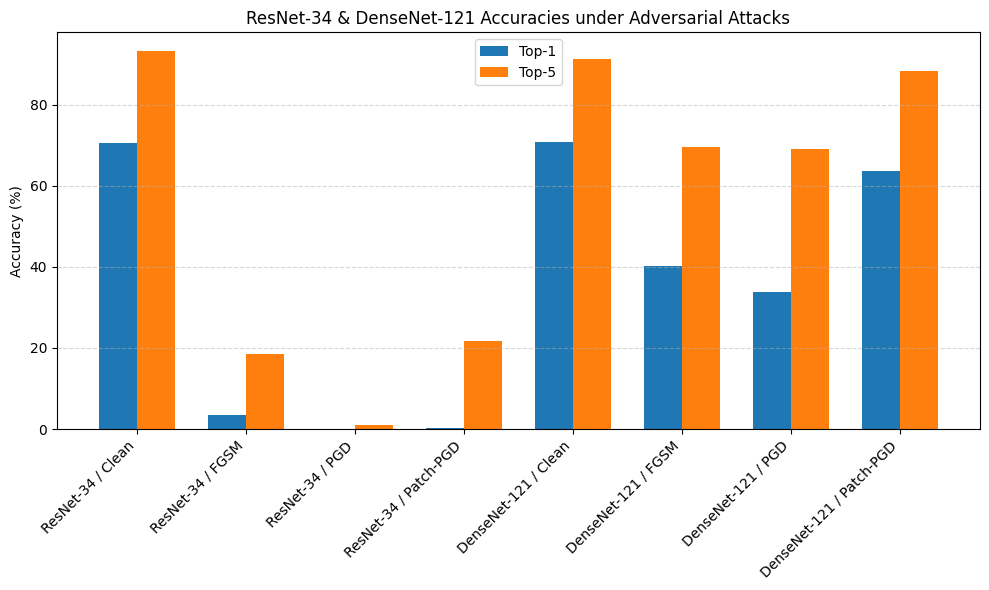

In [ ]:
import pandas as pd                         # for tabular data handling
import matplotlib.pyplot as plt             # for plotting
# Building a list of dictionaries summarizing accuracies and timings
rows = [
    {"Model": "ResNet-34",   "Attack": "Clean",      "Top-1 (%)": top1_accuracy,      "Top-5 (%)": top5_accuracy,       "Gen_Time(s)": t_elapsed,            "Eval_Time(s)": t_elapsed},
    {"Model": "ResNet-34",   "Attack": "FGSM",       "Top-1 (%)": top1_acc,           "Top-5 (%)": top5_acc,            "Gen_Time(s)": t_elapsed_gen_fgsm,  "Eval_Time(s)": t_elapsed_fgsm},
    {"Model": "ResNet-34",   "Attack": "PGD",        "Top-1 (%)": top1_acc_pgd,       "Top-5 (%)": top5_acc_pgd,        "Gen_Time(s)": t_elapsed_gen_pgd,   "Eval_Time(s)": t_elapsed_pgd},
    {"Model": "ResNet-34",   "Attack": "Patch-PGD",  "Top-1 (%)": top1_acc_patch,     "Top-5 (%)": top5_acc_patch,      "Gen_Time(s)": t_elapsed_gen_patch, "Eval_Time(s)": t_elapsed_patch},
    {"Model": "DenseNet-121","Attack": "Clean",      "Top-1 (%)": top1_dense_clean,   "Top-5 (%)": top5_dense_clean,    "Gen_Time(s)": t_elapsed_dense,      "Eval_Time(s)": t_elapsed_dense},
    {"Model": "DenseNet-121","Attack": "FGSM",       "Top-1 (%)": top1_dense_fgsm,    "Top-5 (%)": top5_dense_fgsm,     "Gen_Time(s)": t_elapsed_dense,      "Eval_Time(s)": t_elapsed_dense},
    {"Model": "DenseNet-121","Attack": "PGD",        "Top-1 (%)": top1_dense_pgd,     "Top-5 (%)": top5_dense_pgd,      "Gen_Time(s)": t_elapsed_dense,      "Eval_Time(s)": t_elapsed_dense},
    {"Model": "DenseNet-121","Attack": "Patch-PGD",  "Top-1 (%)": top1_dense_patch,   "Top-5 (%)": top5_dense_patch,    "Gen_Time(s)": t_elapsed_dense,      "Eval_Time(s)": t_elapsed_dense},
]

df = pd.DataFrame(rows)                     # converting list of dicts into DataFrame
# printing a neatly formatted summary table
print("\nAccuracy Summary")
print(df.to_string(index=False, formatters={
    "Top-1 (%)": "{:.2f}%".format,
    "Top-5 (%)": "{:.2f}%".format,
    "Gen_Time(s)": "{:.2f}".format,
    "Eval_Time(s)": "{:.2f}".format
}))

# Creating a bar chart comparing Top-1 vs Top-5 accuracies
fig, ax = plt.subplots(figsize=(10, 6))
x     = range(len(df))                     # positions for each bar group
width = 0.35                               # width of each bar

# plotting Top-1 bars offset to the left
ax.bar([i - width/2 for i in x], df["Top-1 (%)"], width, label="Top-1")
# plotting Top-5 bars offset to the right
ax.bar([i + width/2 for i in x], df["Top-5 (%)"], width, label="Top-5")

# set x-tick labels to "Model / Attack"
ax.set_xticks(x)
ax.set_xticklabels(df["Model"] + " / " + df["Attack"], rotation=45, ha="right")
ax.set_ylabel("Accuracy (%)")              # y-axis label
ax.set_title("ResNet-34 & DenseNet-121 Accuracies under Adversarial Attacks")
ax.legend()                                # showing legend
ax.grid(axis="y", linestyle="--", alpha=0.5)  # horizontal grid lines for readability

plt.tight_layout()                         # adjusting layout to fit labels
plt.show()                                 # displaying the plot


### Conclusion

**Task 1 – Baseline Performance:**
Both ResNet-34 and DenseNet-121 demonstrated strong clean accuracy—around 70% Top-1 and over 90% Top-5—reflecting their ability to learn discriminative, semantically meaningful features across 100 ImageNet classes. From a theoretical standpoint, this baseline confirms that their high-capacity architectures and well-tuned training procedures produce decision boundaries that cleanly separate most natural images. DenseNet’s dense connectivity appears to marginally boost Top-1 robustness, suggesting its feature reuse and smoother gradient propagation yield slightly wider classification margins around in-distribution samples.

**Task 2 – FGSM Attack:**
The one-step FGSM attack exploits the network’s local linearity by perturbing inputs in the sign of the loss gradient. Theoretically, FGSM approximates the worst-case change under a small ℓ∞ budget by walking along the steepest ascent direction in pixel space. ResNet-34’s collapse to ≈ 3% Top-1 reveals its susceptibility to small, non-robust feature shifts, while DenseNet-121’s retention of ≈ 40% Top-1 highlights how distributed gradient flow and denser skip connections dampen the effect of single-step perturbations.

**Task 3 – PGD Attack:**
PGD refines FGSM by iteratively traversing the highest-curvature directions of the loss landscape, effectively approximating the inner maximization of a robust optimization objective. Its multi-step nature uncovers deeper adversarial “valleys” that one-step methods miss. ResNet-34’s Top-1 accuracy falls to near zero, and DenseNet-121 drops to ≈ 34%—a testament to PGD’s ability to navigate complex boundary geometry and find adversarial pockets even in models with smoother gradient distributions.

**Task 4 – Patch-PGD Attack:**
Confining perturbations to a small contiguous patch taps into localized vulnerabilities and tests a model’s reliance on salient regions. From a theoretical lens, patch attacks optimize within a low-dimensional subspace defined by the patch mask, yet still succeed if that patch overlaps critical features. ResNet-34 is effectively broken—Top-1 ≈ 0.2%—indicating its decision function can be hijacked by minimal, strategically placed noise. DenseNet-121, by contrast, maintains ≈ 64% Top-1, showing that architectures with global pooling and highly entangled feature maps buffer against localized distortions.

**Task 5 – Transferability & Model Comparison:**
Across all attacks we observe a clear hierarchy of attack potency (Patch-PGD ≳ PGD > FGSM > clean) and model robustness (DenseNet-121 > ResNet-34). Transferability—the ability of perturbations crafted on one model to fool another—depends on the alignment of their loss landscapes. DenseNet’s re-use of features and smoother gradients decorrelates its boundary geometry from ResNet’s, reducing transfer from ResNet-crafted attacks. This asymmetry underscores the value of architectural diversity in ensemble defenses.

**Lessons & Mitigations:**
Adversarial perturbations target “non-robust” features—subtle statistical patterns that networks exploit but humans ignore. To defend, one must push the network to rely on robust, semantically grounded features via adversarial training, which integrates worst-case examples into the learning objective. Ensemble or randomized‐architecture approaches break the consistency of gradient directions, thwarting white-box transfer. Input transformations (e.g., random resizing, compression, denoising) project inputs onto a smoother manifold, disrupting aligned noise. Certified defenses like randomized smoothing offer probabilistic guarantees under norm bounds by averaging predictions over noisy inputs. Finally, for localized patch attacks, detecting anomalous patches—by monitoring local gradient magnitudes or texture statistics—and inpainting them can neutralize malicious regions. A holistic defense combines robust training objectives, architectural design, runtime randomization, and input sanitization to guard against both global and localized adversarial threats.